In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize']=[10,5]
plt.rcParams['figure.dpi']=300
%matplotlib inline

In [46]:
df = pd.read_csv('/content/exchange_rate.csv',parse_dates=['date'])
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [47]:
df['date'] = pd.to_datetime(df.date, format="%d-%m-%Y %H:%M")
df.head()

,date,Ex_rate
0,1990-01-01,0.7855
1,1990-01-02,0.7818
2,1990-01-03,0.7867
3,1990-01-04,0.7860
4,1990-01-05,0.7849


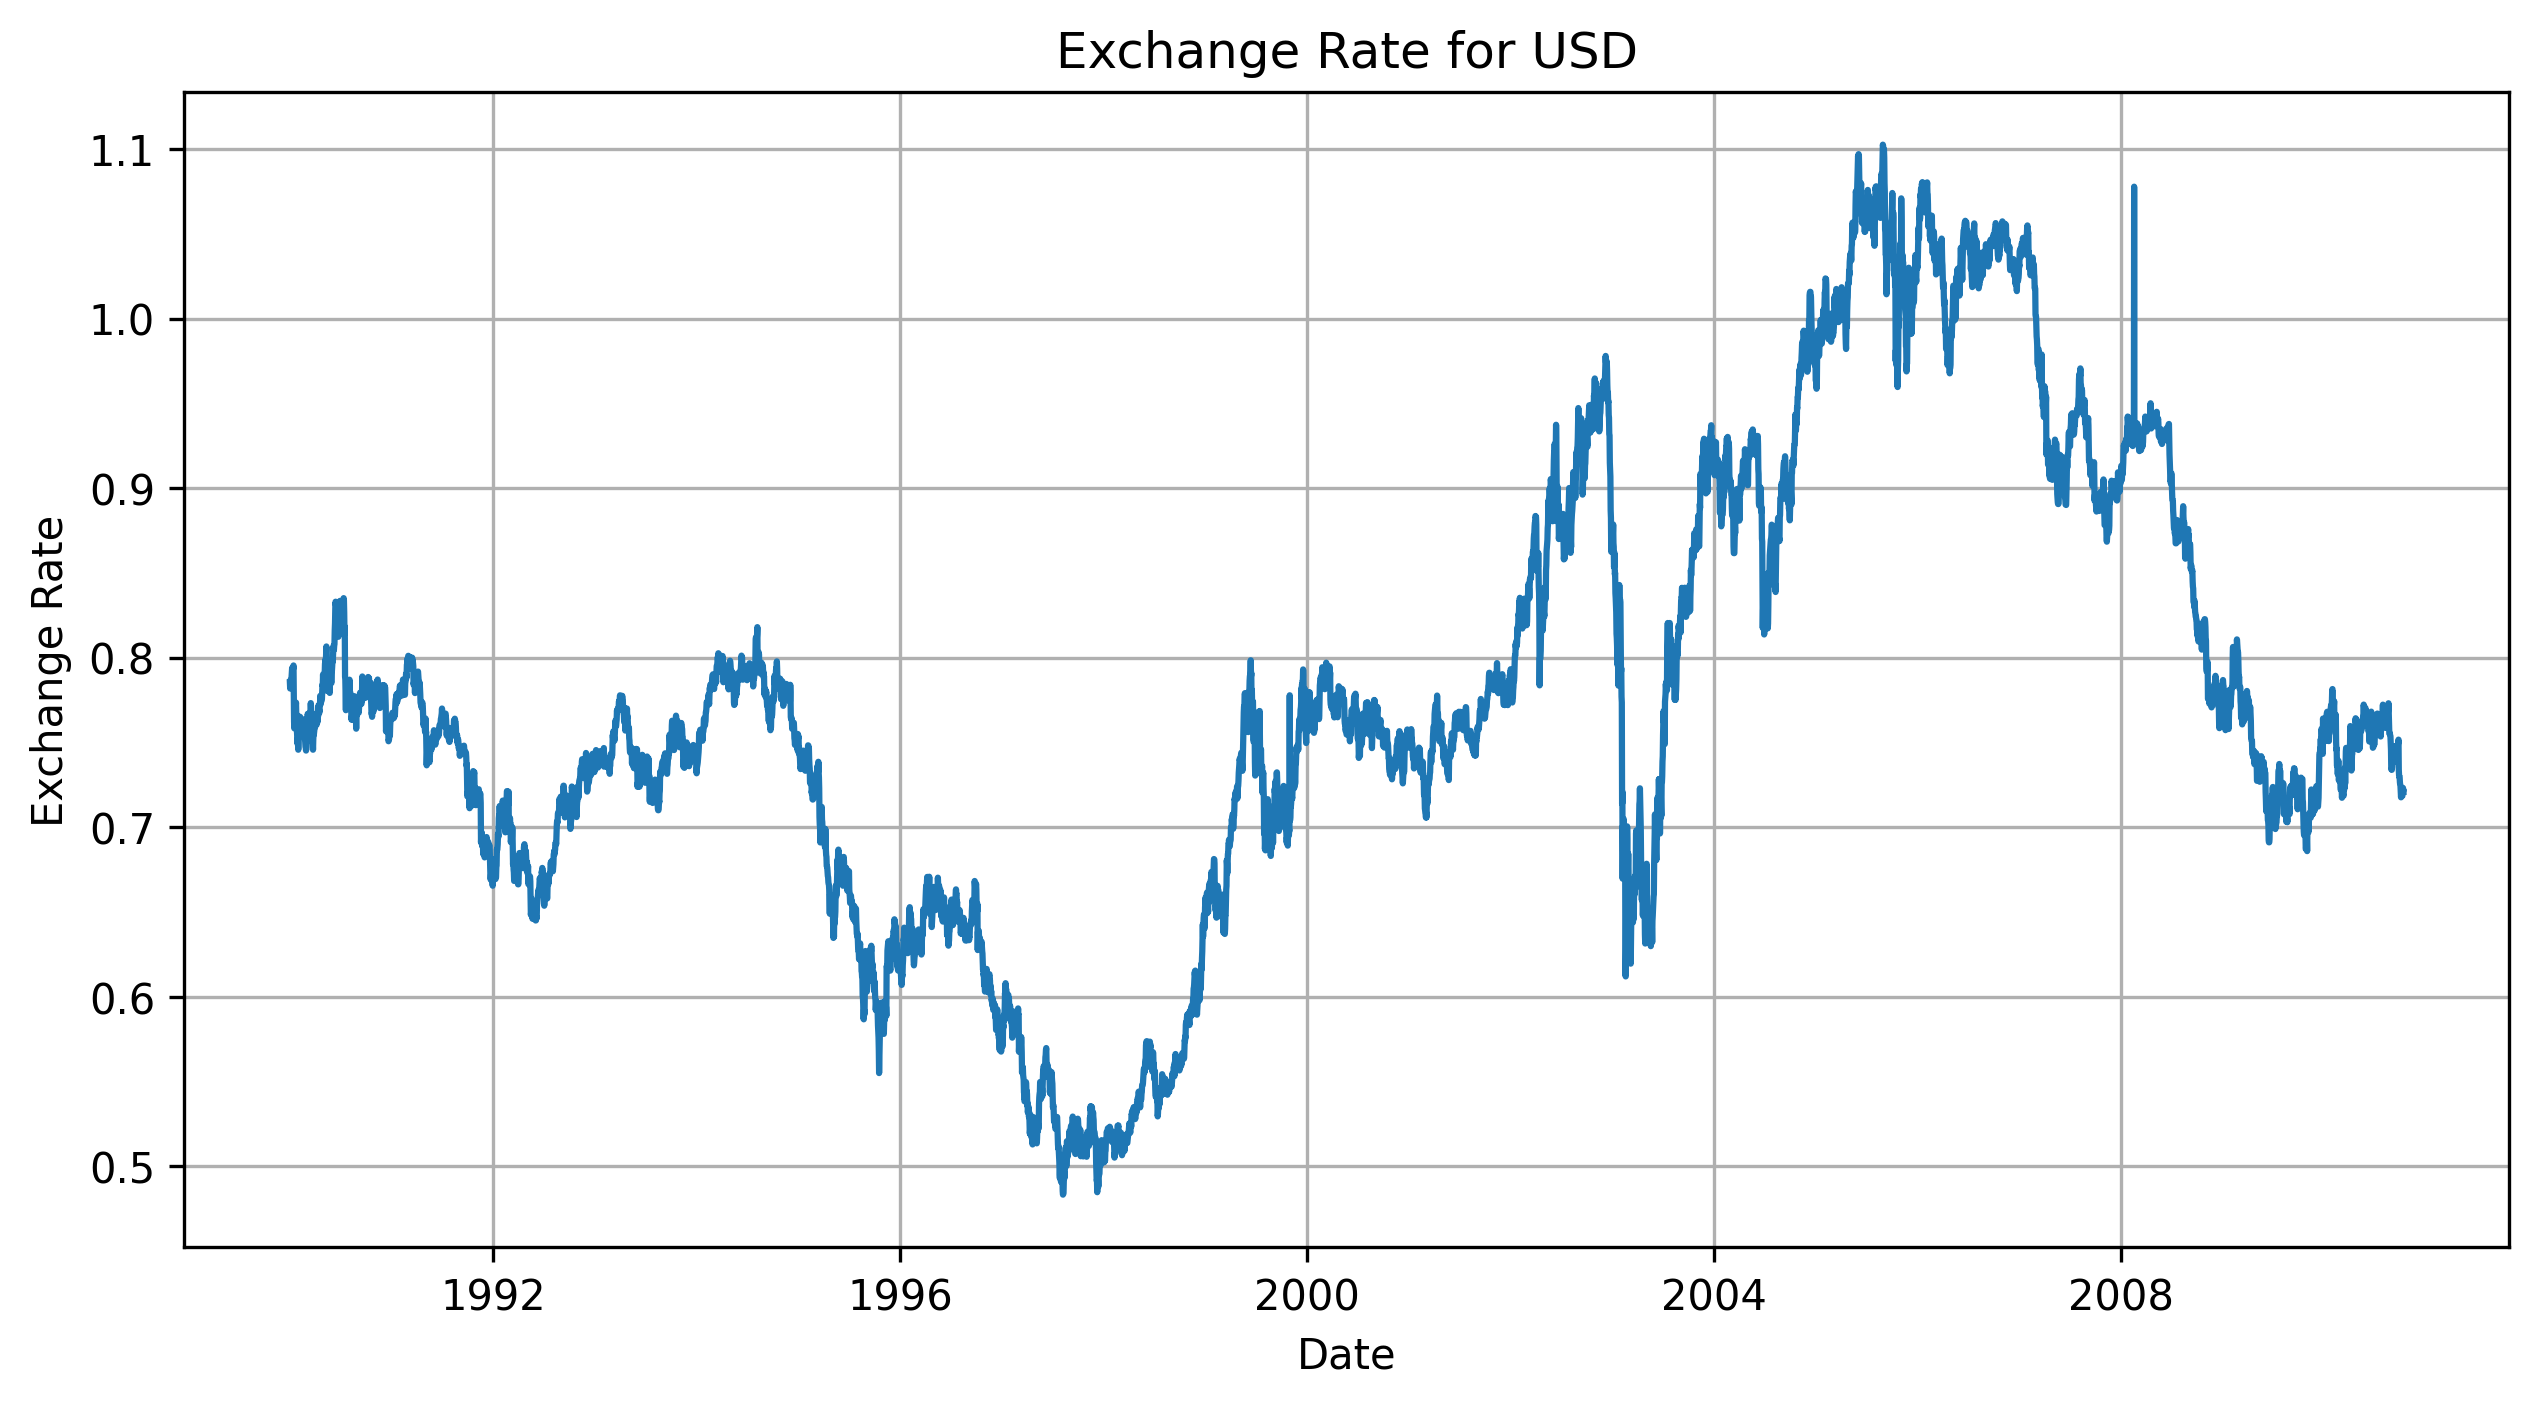

In [48]:
plt.plot(df['date'],df['Ex_rate'])
plt.title('Exchange Rate for USD')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.grid(True)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     7588 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.7 KB


In [50]:
df.isna().sum()

,0
date,0
Ex_rate,0


In [51]:
df.duplicated().sum()

0

array([[<Axes: title={'center': 'date'}>,
        <Axes: title={'center': 'Ex_rate'}>]], dtype=object)

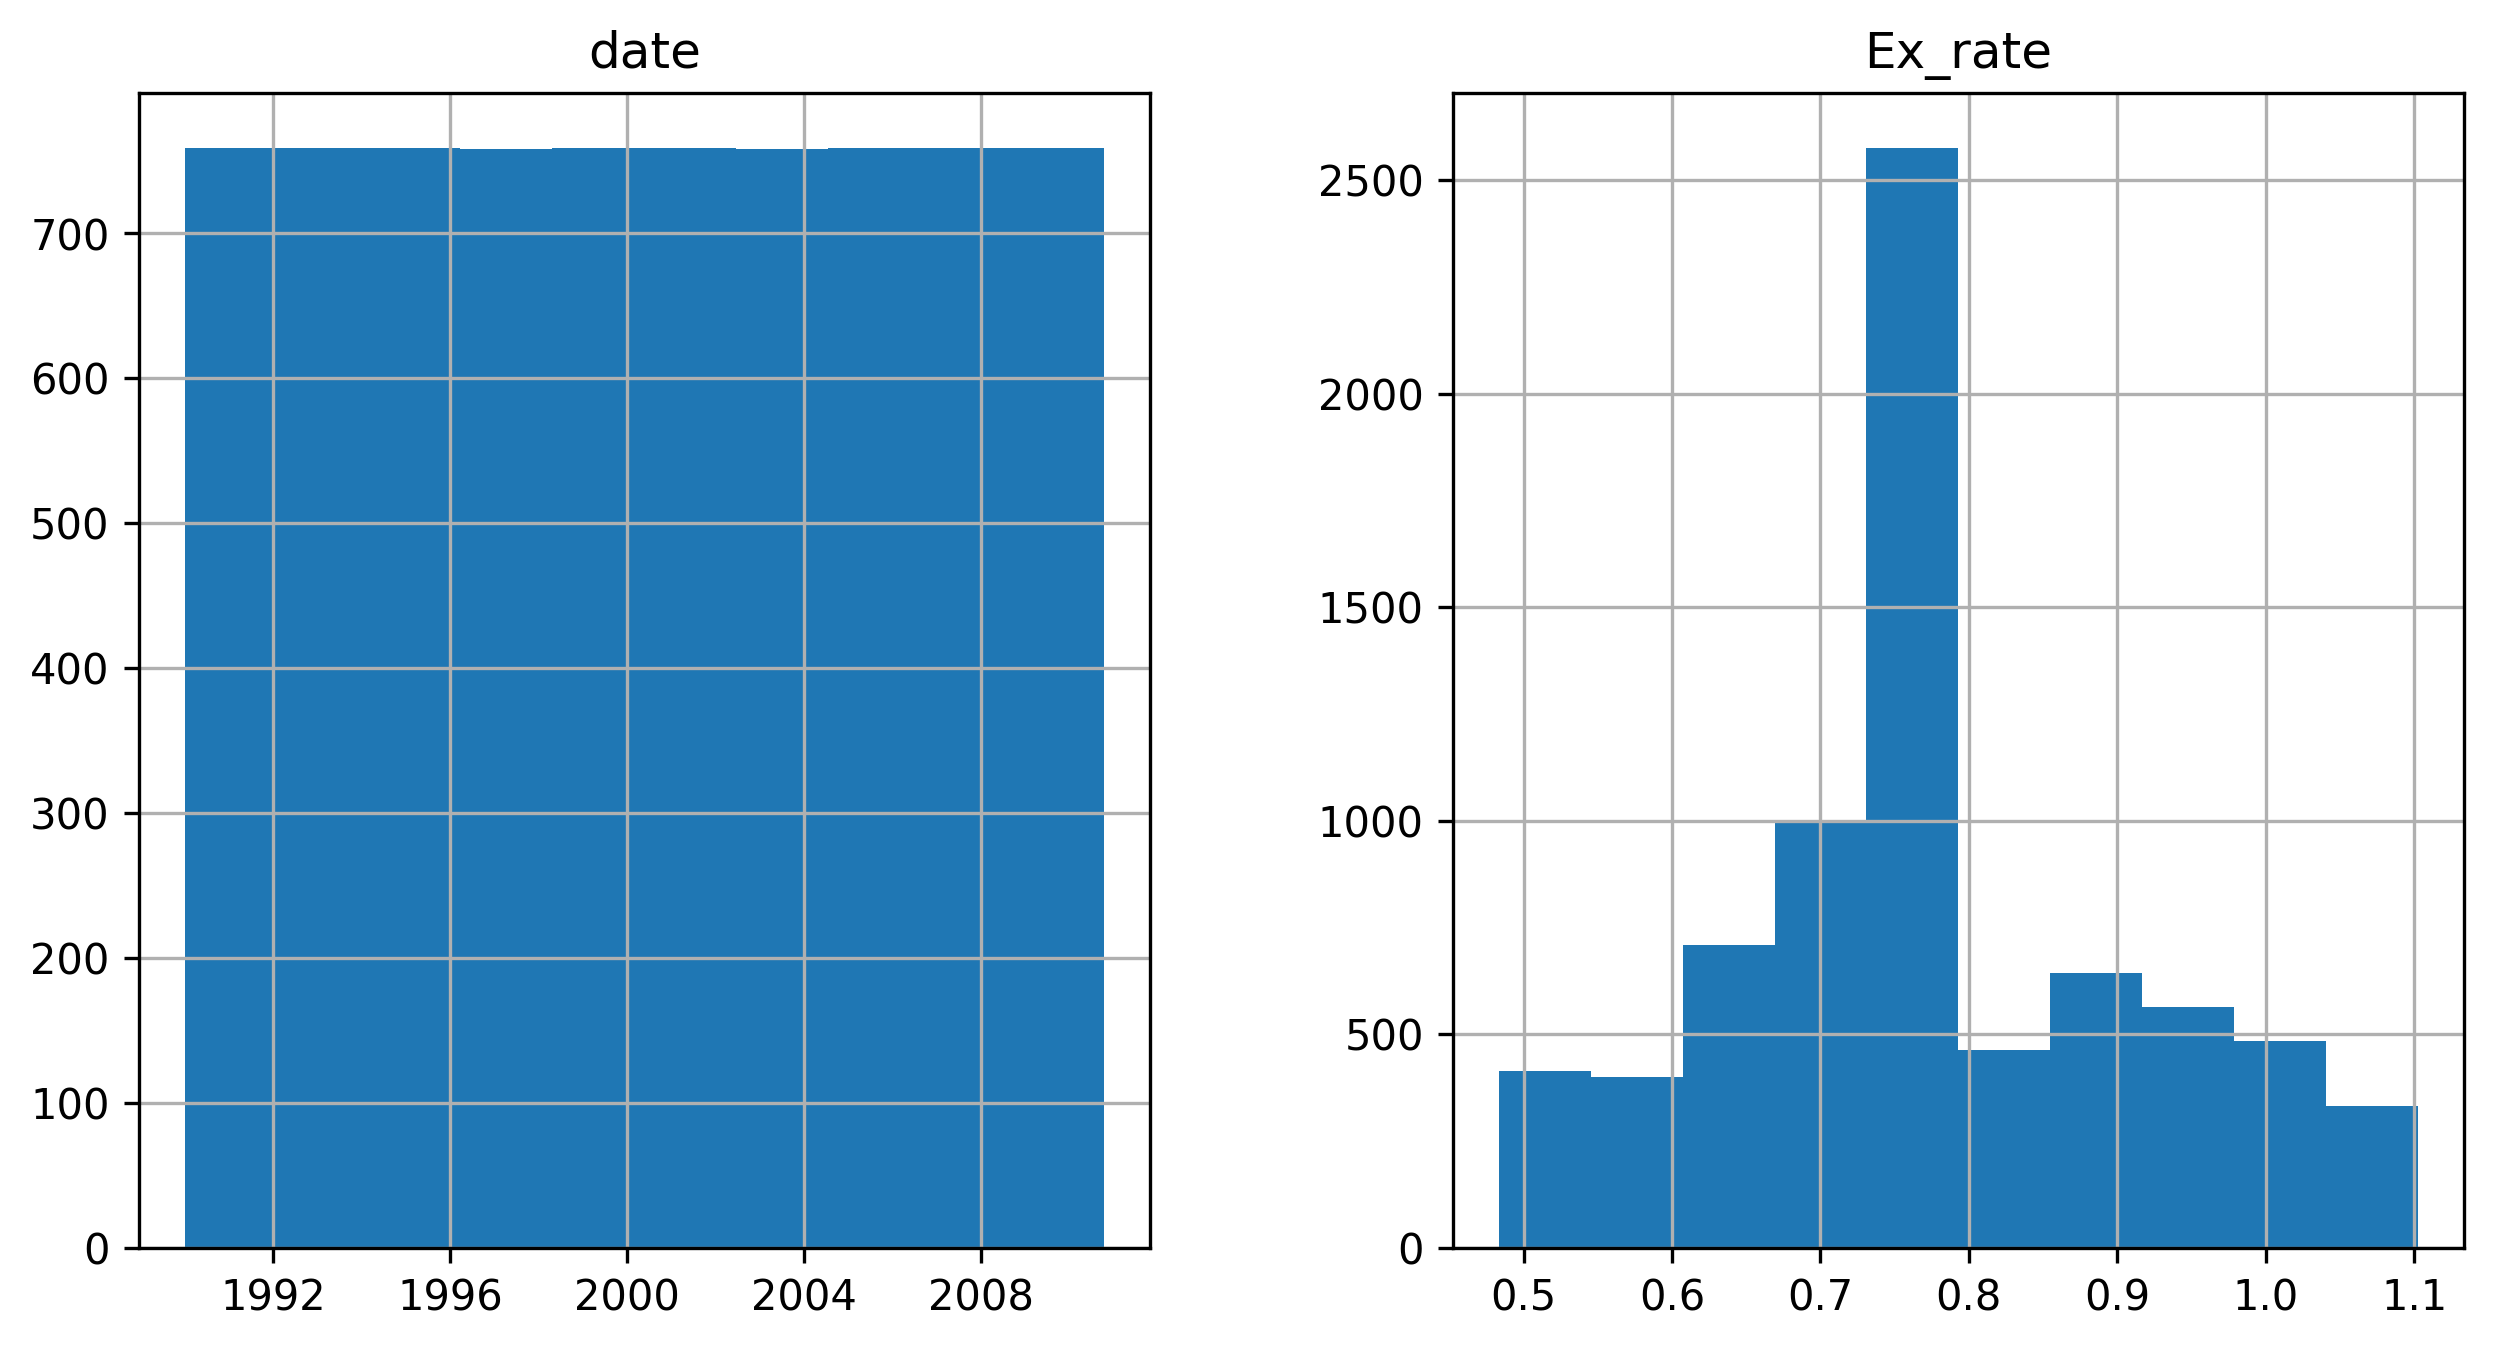

In [52]:
df.hist()

<Axes: >

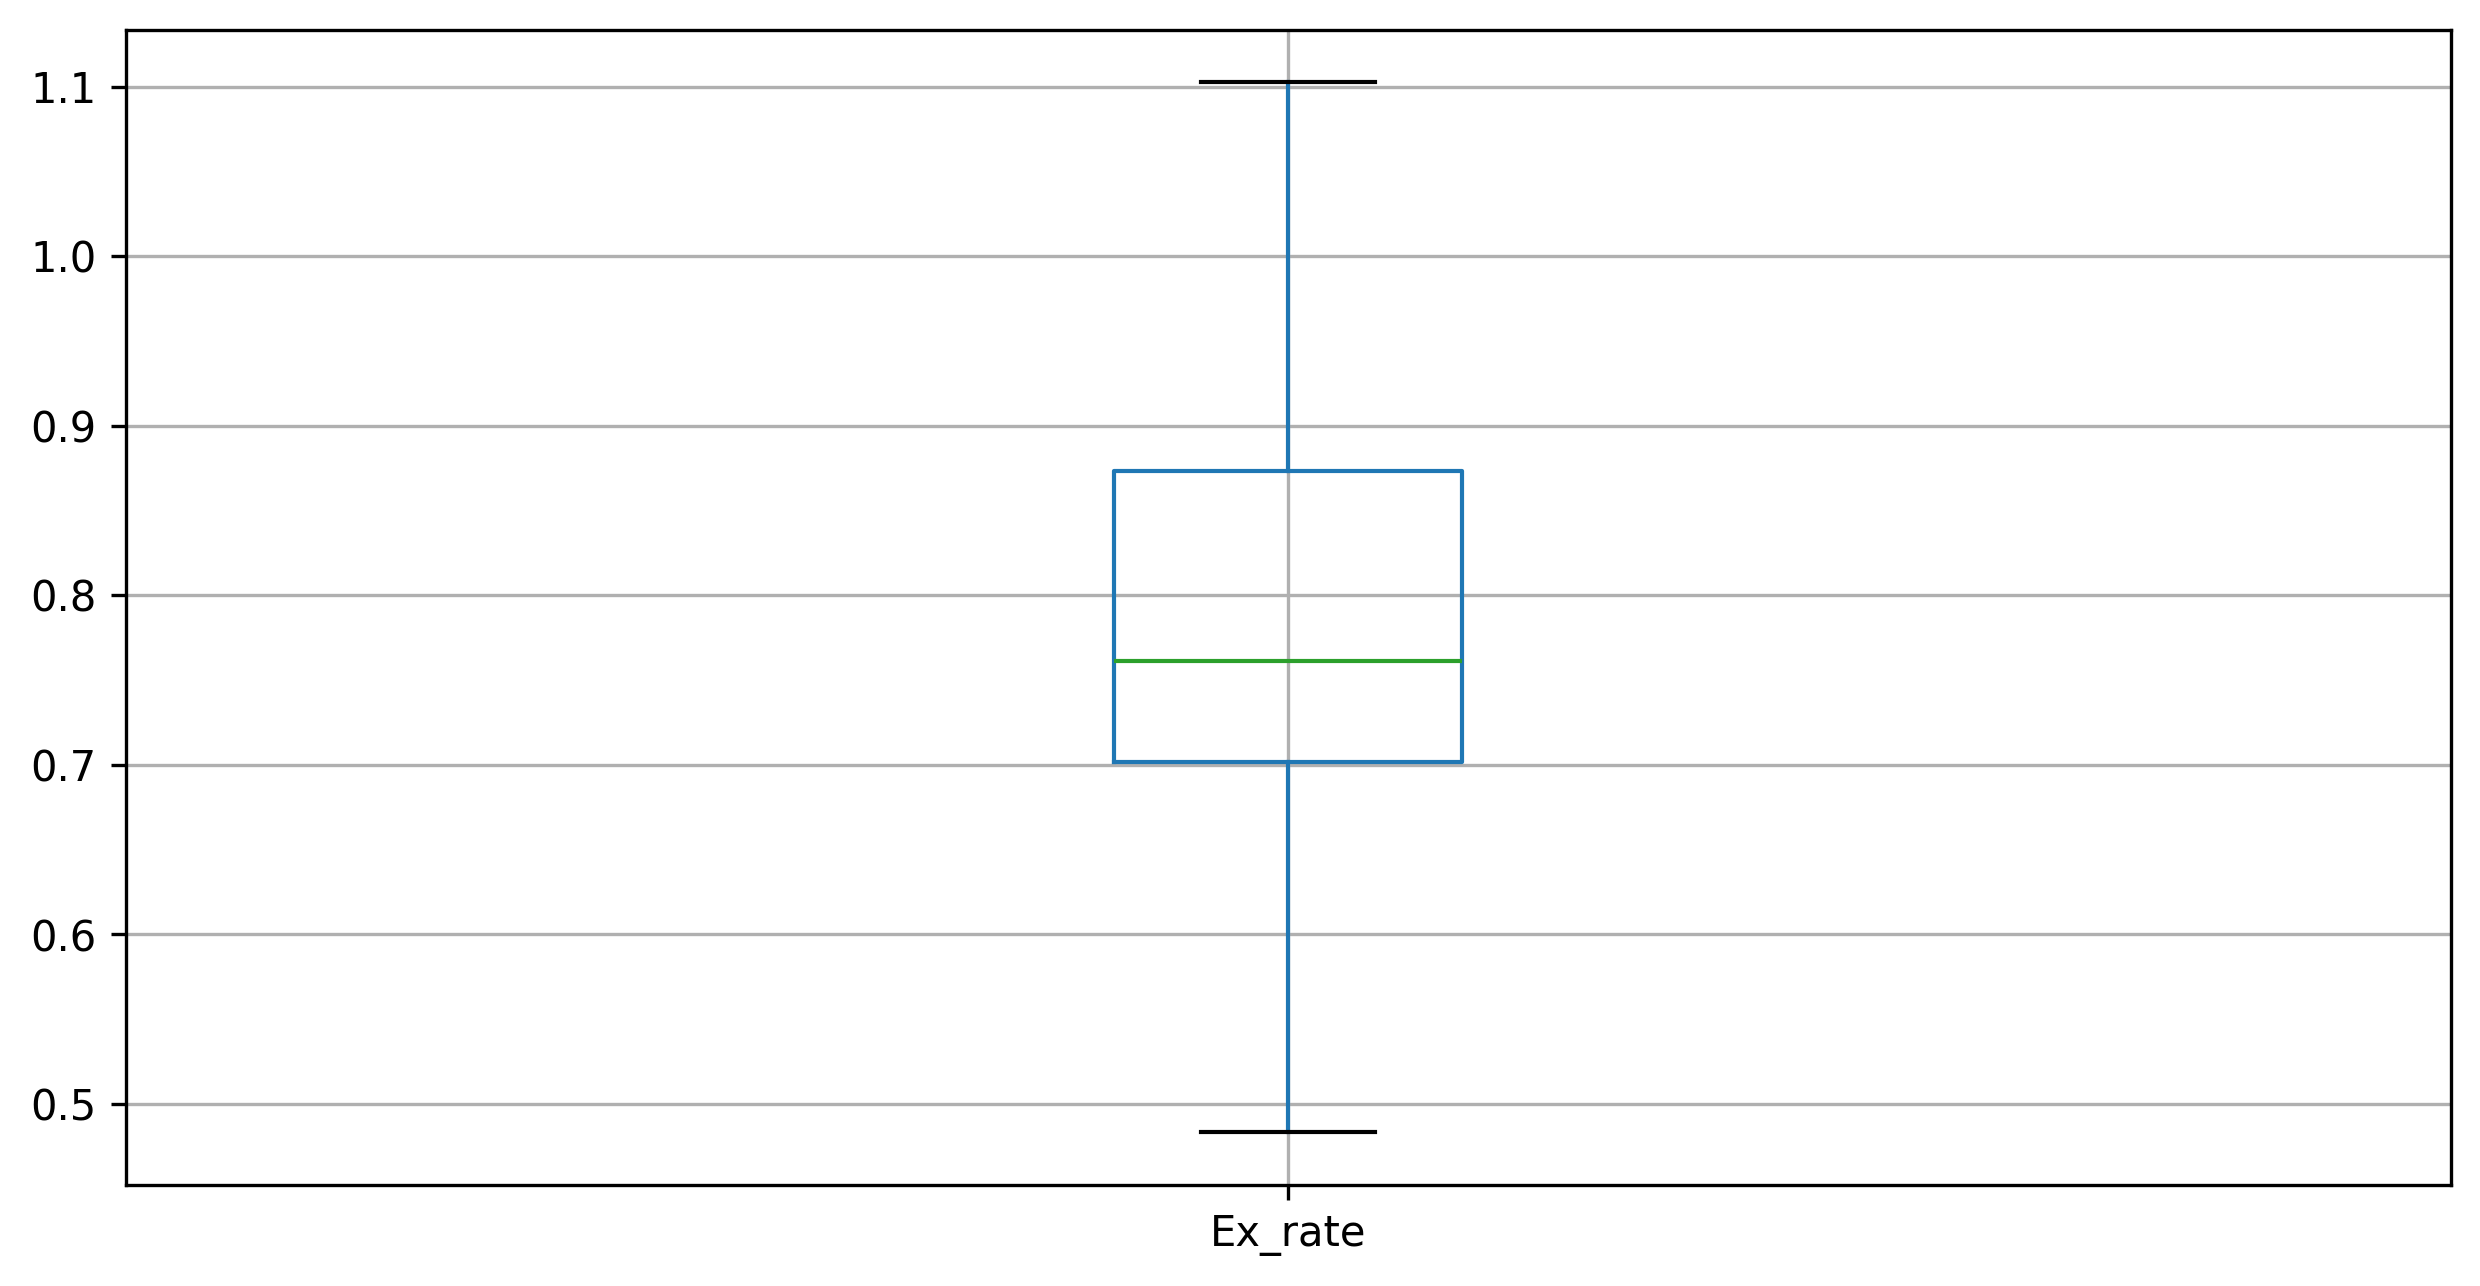

In [53]:
df.boxplot()

**Model Building**


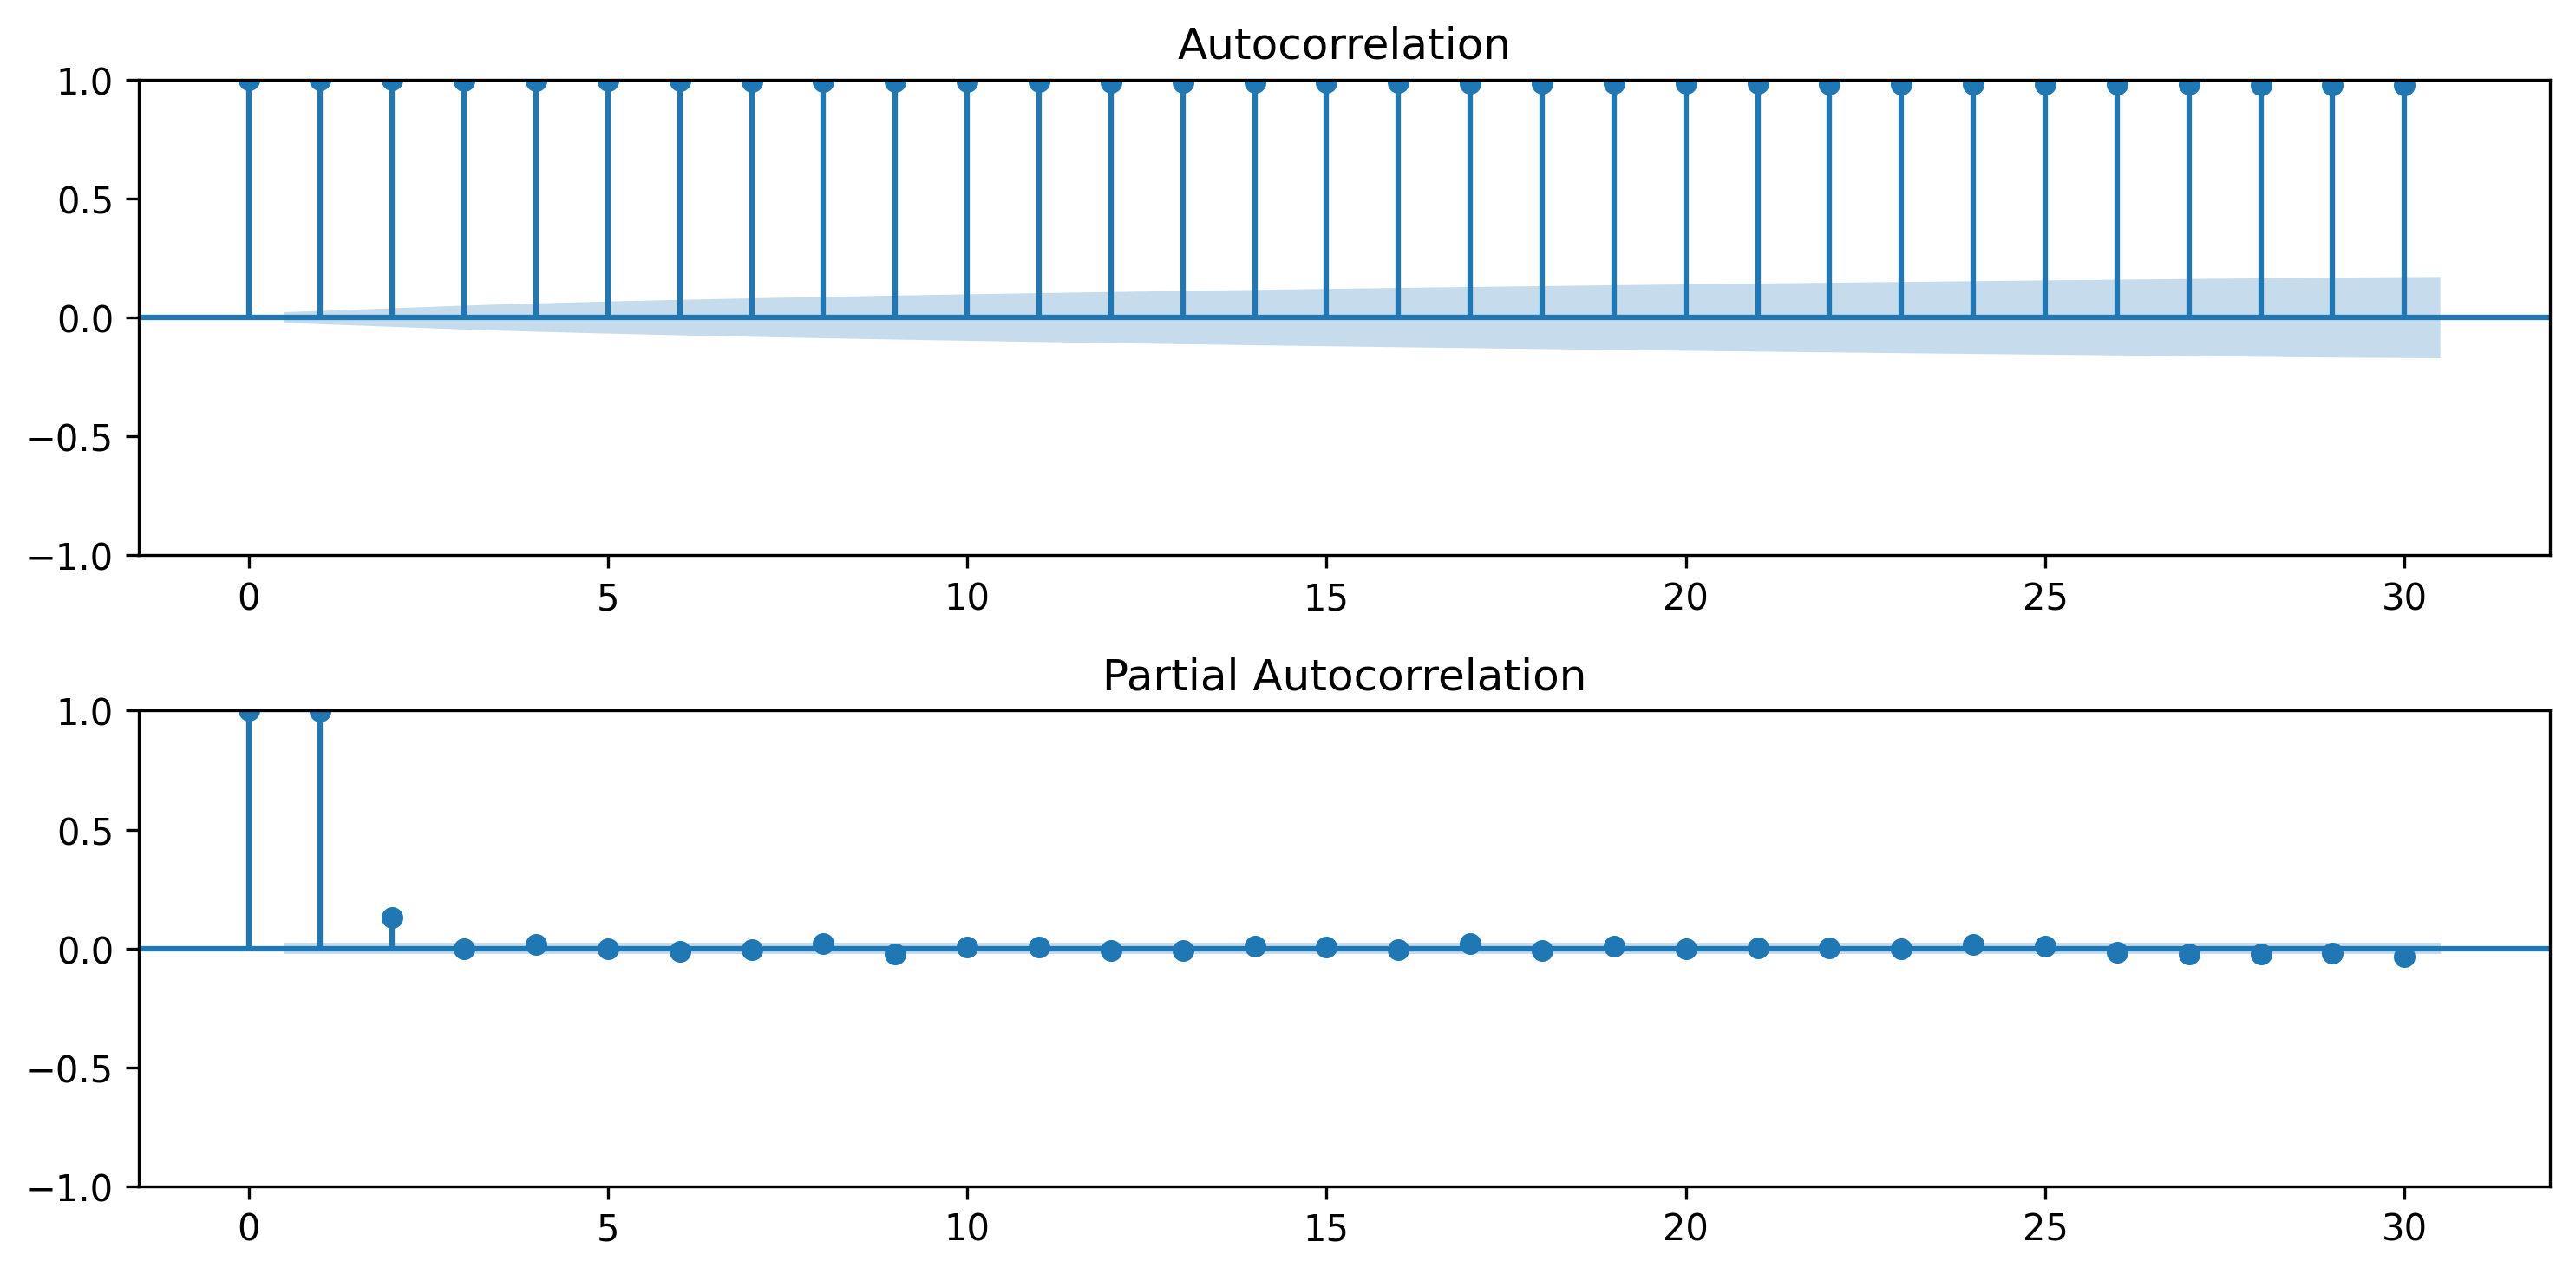

In [54]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt



# Plot ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(10, 5))

plot_acf(df['Ex_rate'], lags=30, ax=axes[0])  # Adjust 'lags' as needed
plot_pacf(df['Ex_rate'], lags=30, ax=axes[1]) # Adjust 'lags' as needed

plt.tight_layout()
plt.show()

In [55]:
!pip install pmdarima

In [56]:
from statsmodels.tsa.stattools import adfuller
# adfuller checks the data is stationary or non_stationary

from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima


<Axes: >

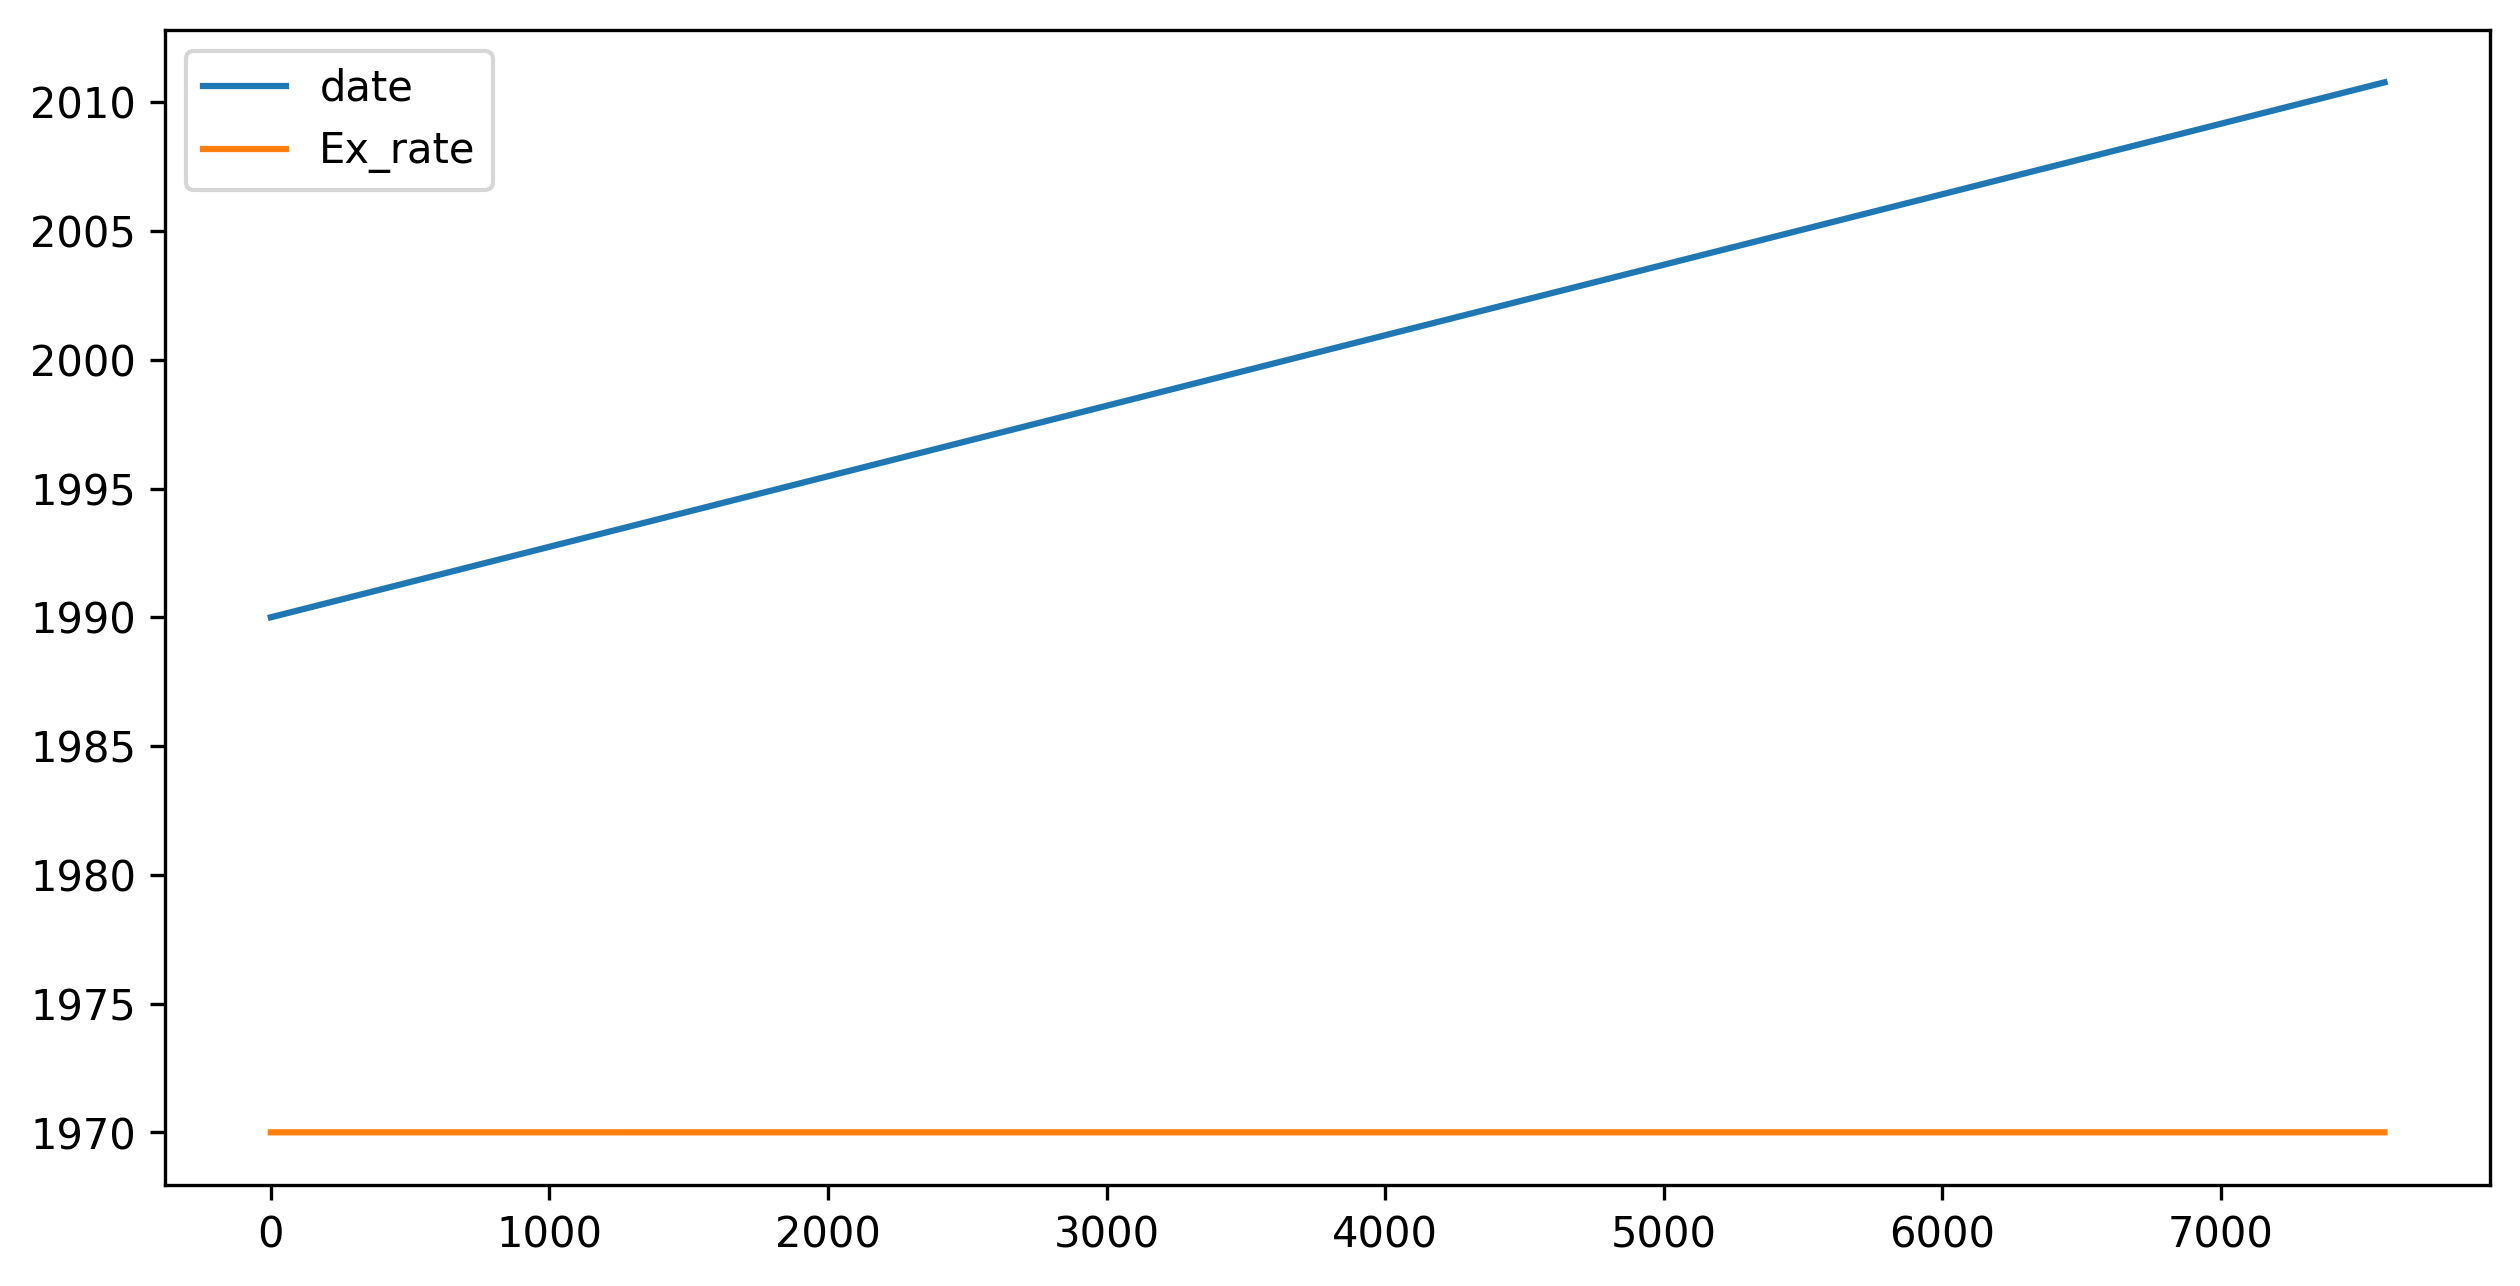

In [57]:
df.plot()

In [58]:
adfuller(df['Ex_rate'])[1]

0.4492327353597477

In [59]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Ex_rate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477


In [60]:
# here we can see that the adfuller value is greater than 0.05 alpha value . so this data is non_stationary
# first we convert into stationary data


df['diff_Ex_rate'] = df['Ex_rate'].diff()
df['diff_Ex_rate']

,diff_Ex_rate
0,NaN
1,-0.003700
2,0.004900
3,-0.000700
4,-0.001100
...,...
7583,-0.000207
7584,0.003345
7585,0.001358
7586,-0.002372


In [61]:
df['diff_Ex_rate'].dtypes

dtype('float64')

In [62]:
df['diff_Ex_rate'].fillna(0,inplace=True)
df.head()

,date,Ex_rate,diff_Ex_rate
0,1990-01-01,0.7855,0.0000
1,1990-01-02,0.7818,-0.0037
2,1990-01-03,0.7867,0.0049
3,1990-01-04,0.7860,-0.0007
4,1990-01-05,0.7849,-0.0011


In [66]:
result = adfuller(df['diff_Ex_rate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# now this data is in  form of stationary

ADF Statistic: -99.39751231950207
p-value: 0.0


In [70]:
order = auto_arima(df['diff_Ex_rate'])


In [76]:
order

ARIMA(order=(1, 0, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [80]:
# Replace (p, d, q) with the values you estimated
model = ARIMA(df['diff_Ex_rate'], order=(1,0,0))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           diff_Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 0, 0)   Log Likelihood               28058.364
Date:                Wed, 11 Dec 2024   AIC                         -56110.727
Time:                        06:19:00   BIC                         -56089.924
Sample:                             0   HQIC                        -56103.588
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.766e-06   6.37e-05     -0.138      0.891      -0.000       0.000
ar.L1         -0.1314      0.002    -61.556      0.000      -0.136      -0.127
sigma2      3.595e-05   1.01e-07    355.493      0.0

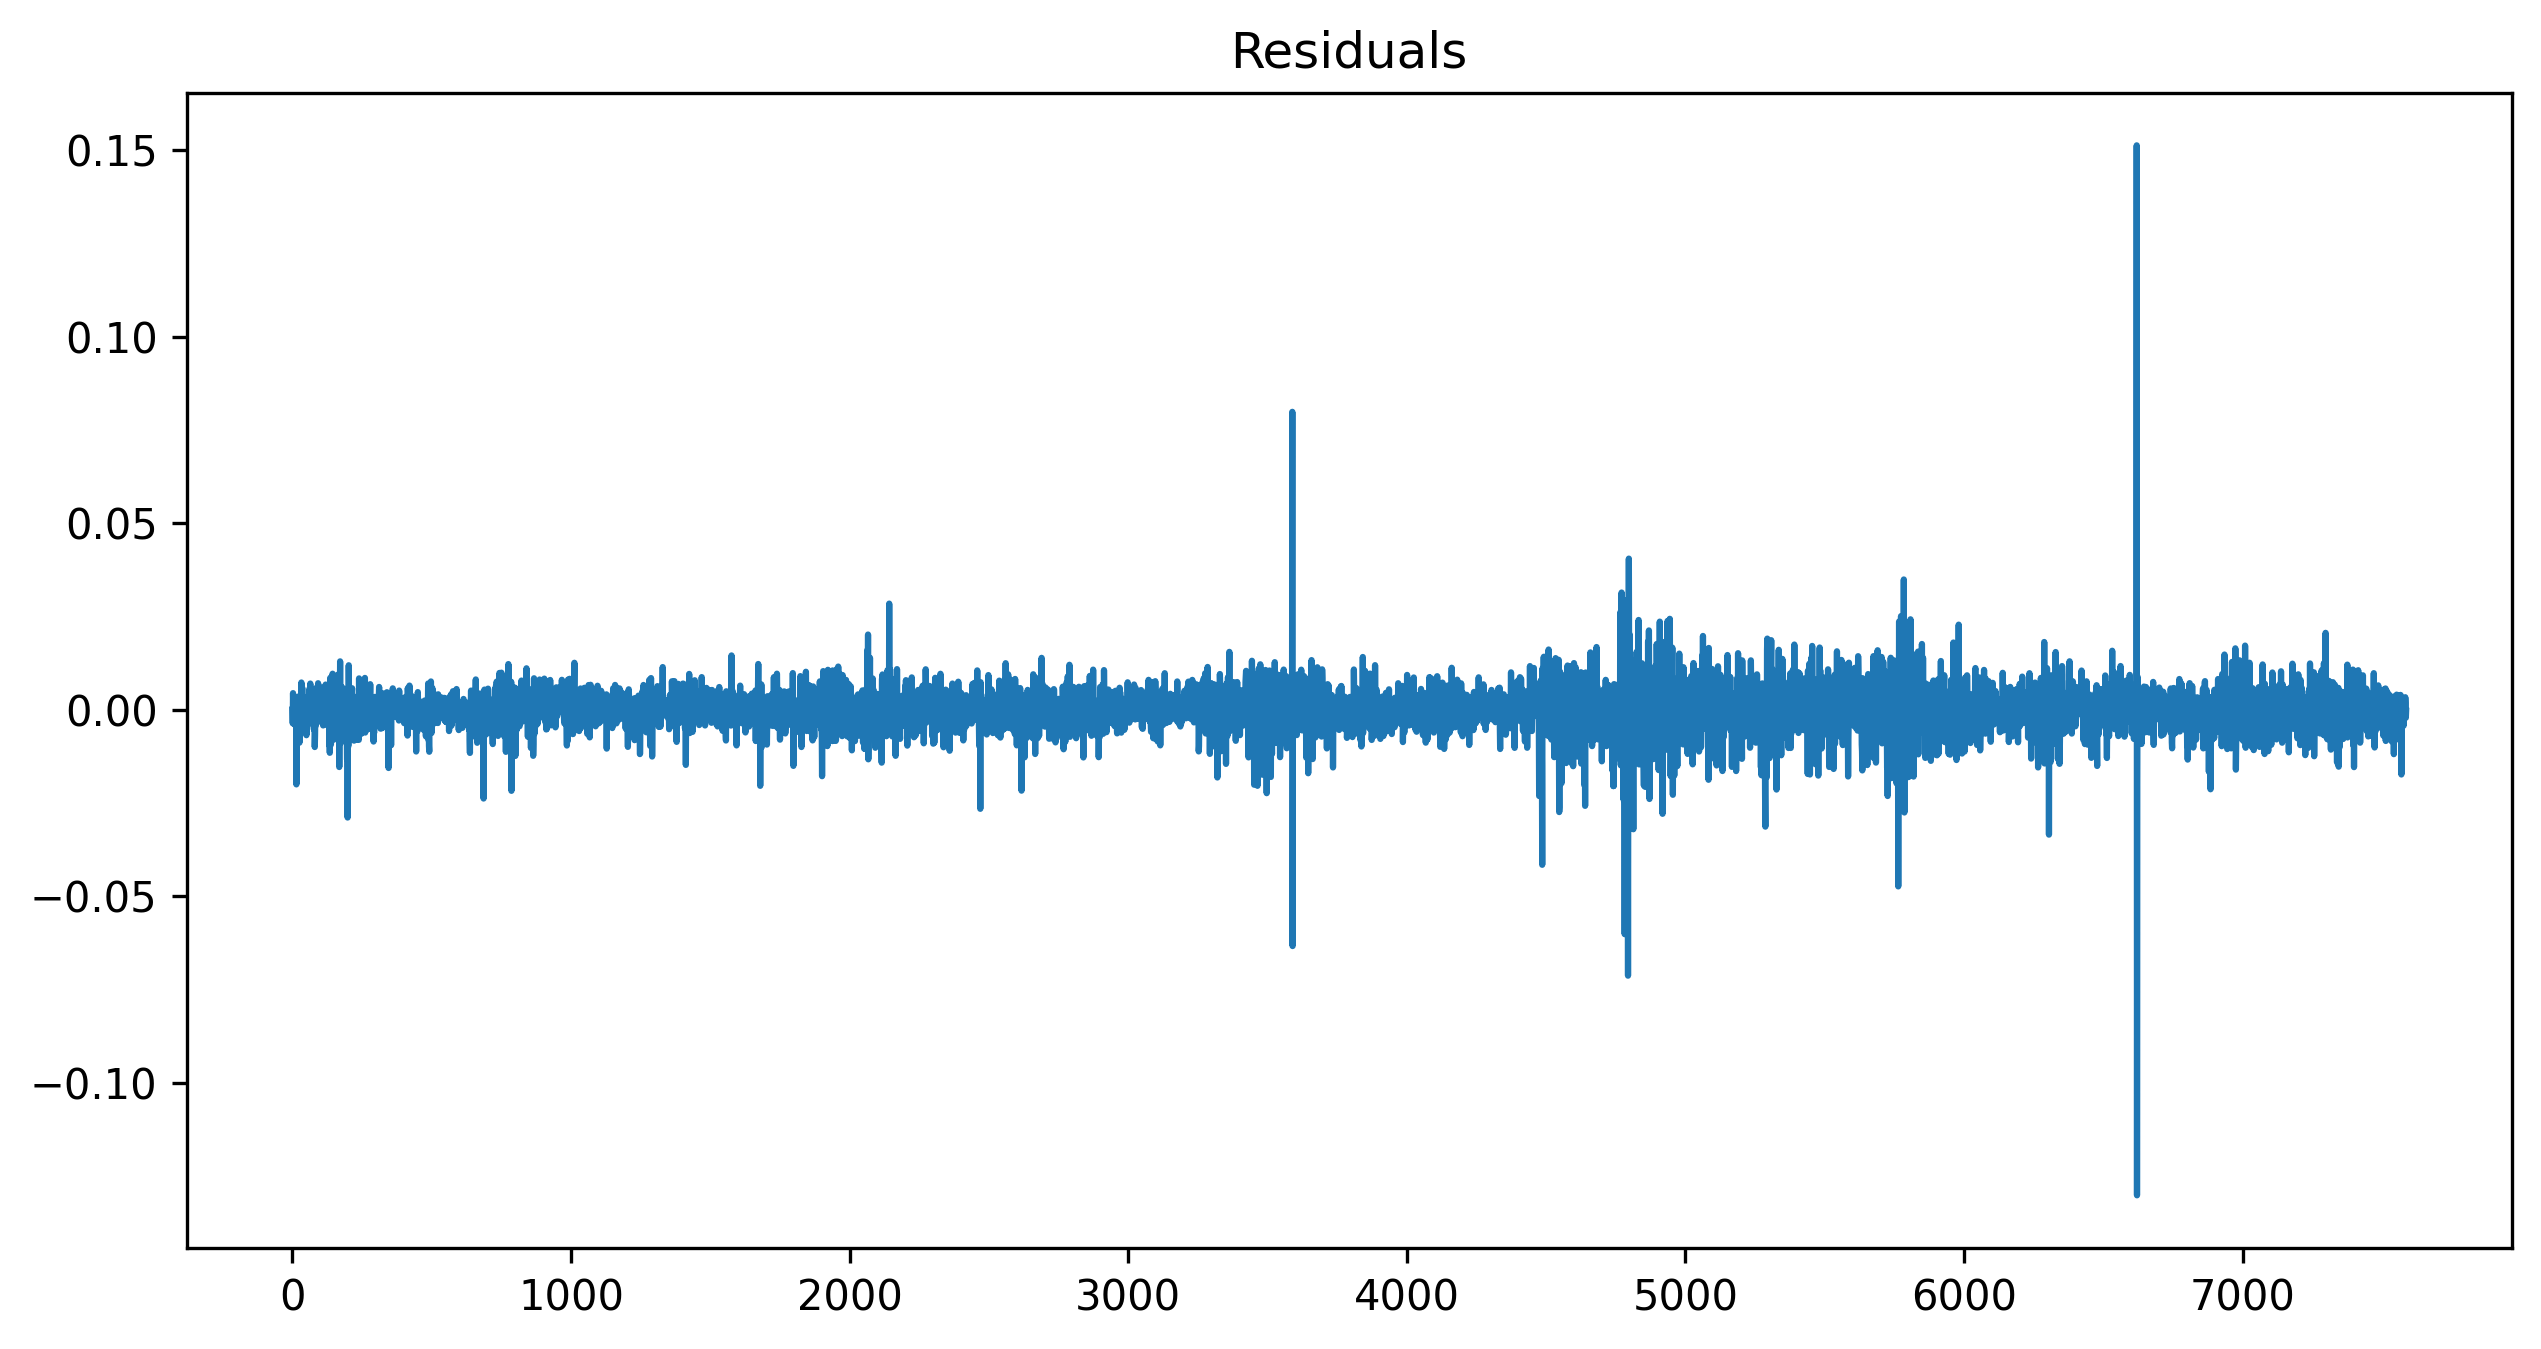

In [81]:
# Analyze residuals
residuals = model_fit.resid
plt.plot(residuals)
plt.title('Residuals')
plt.show()

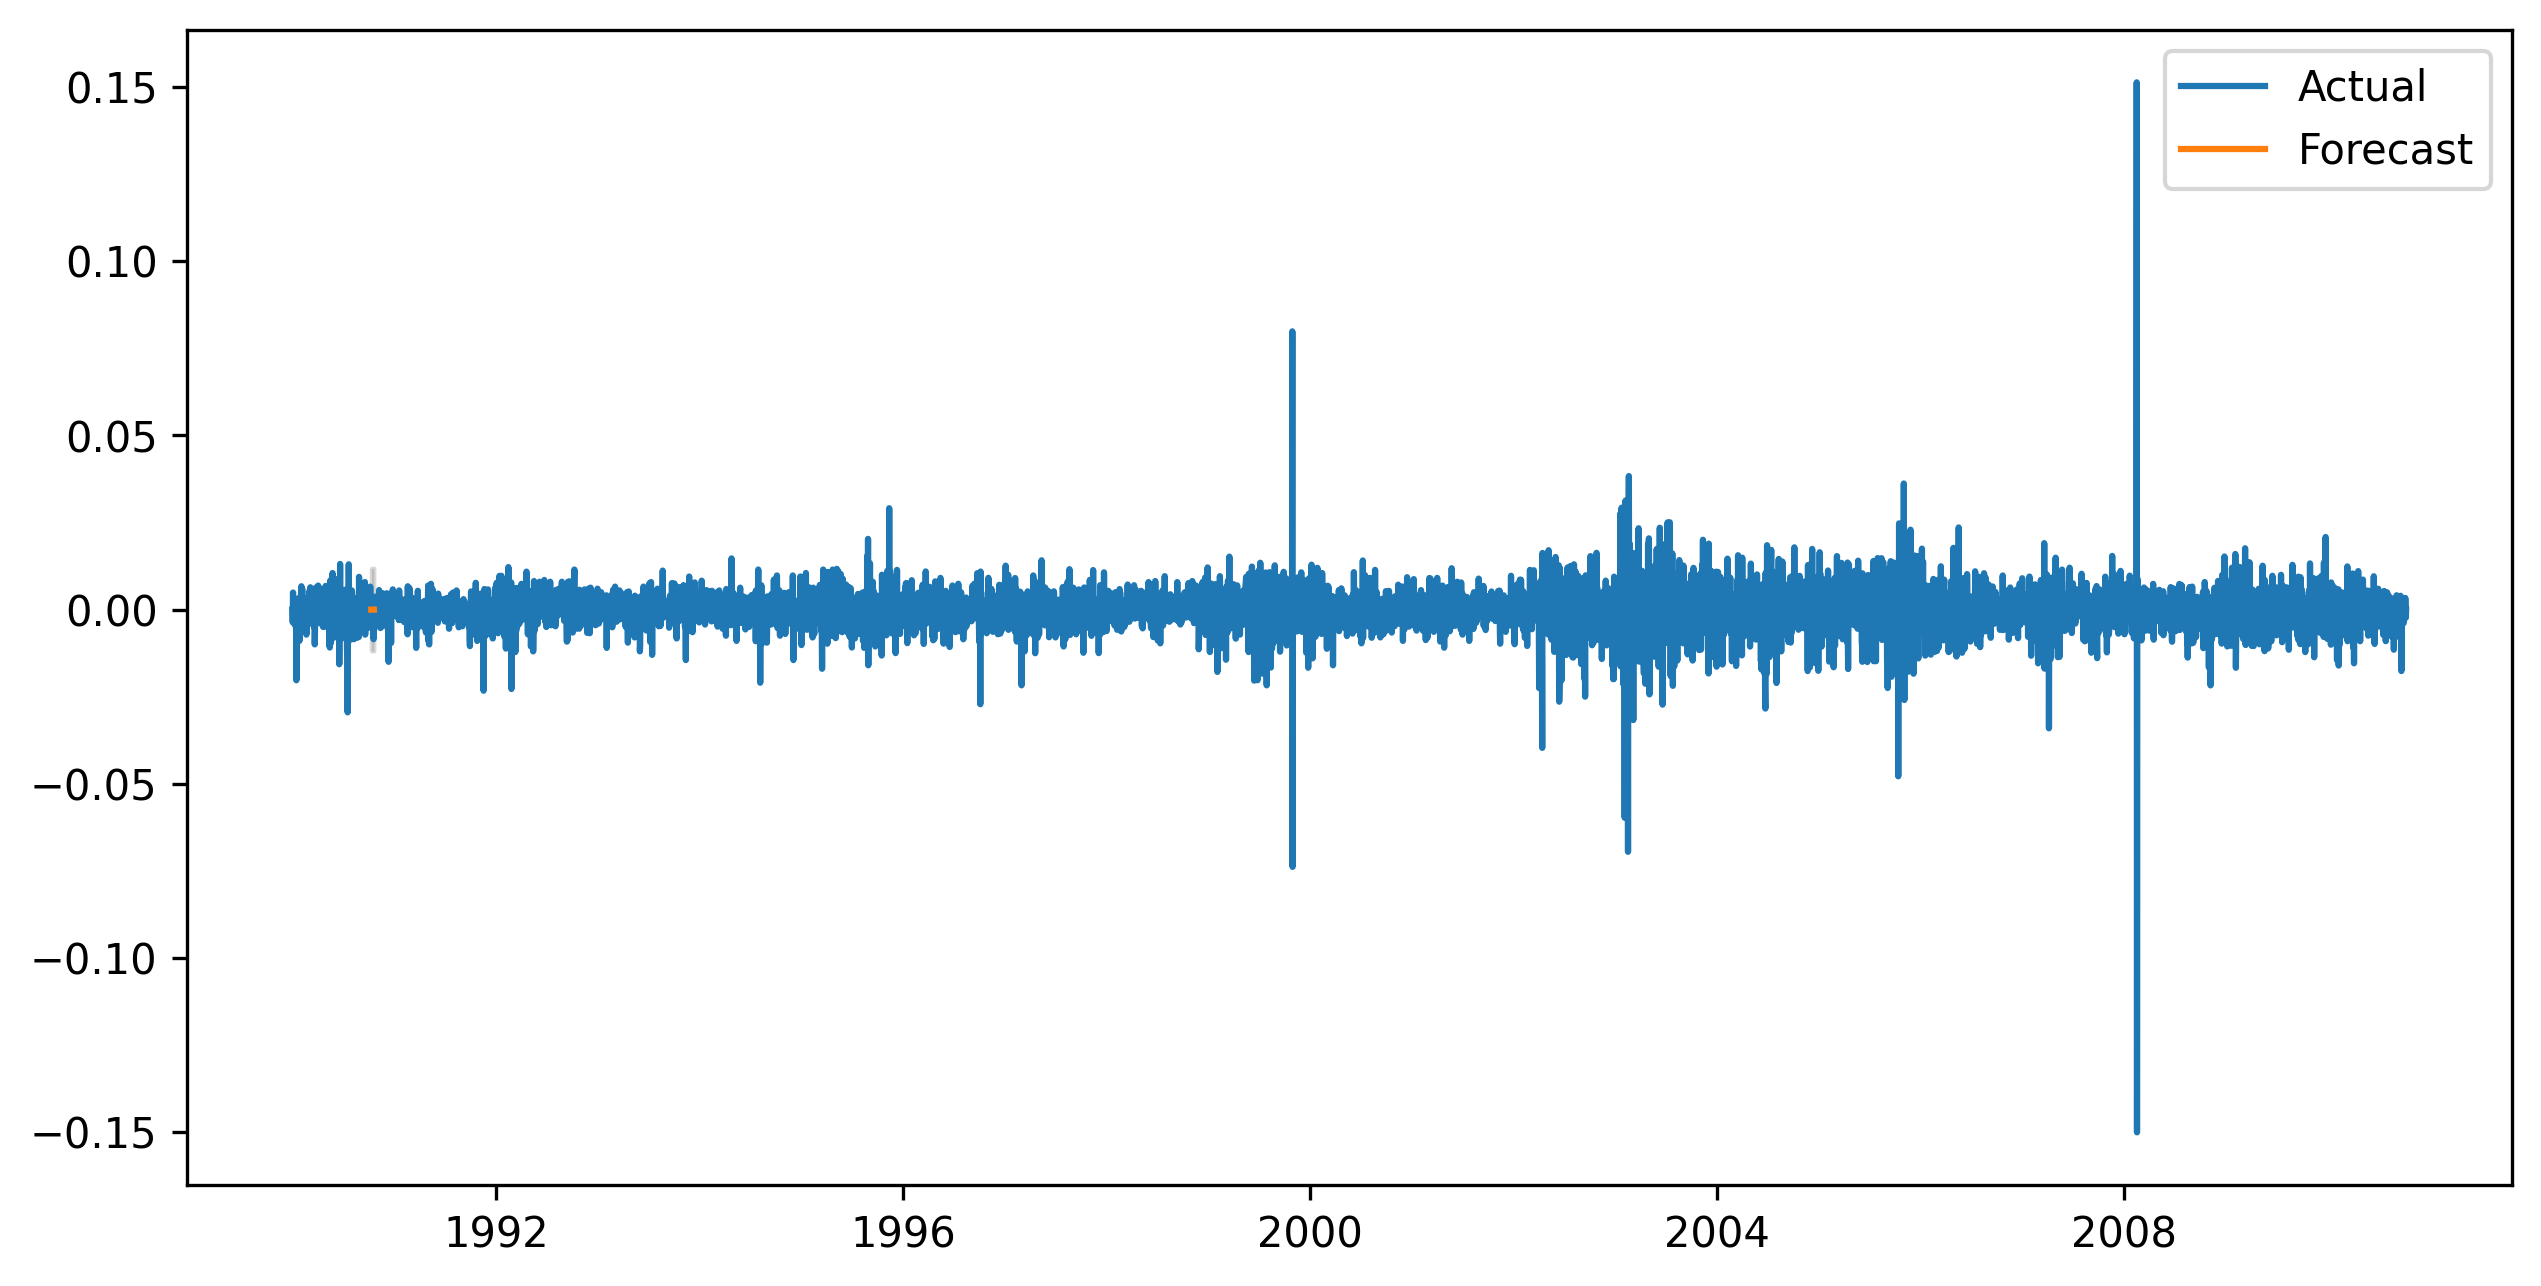

In [84]:
# Forecast future values
forecast = model_fit.get_forecast(steps=10)  # Adjust 'steps' for the desired forecast horizon
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Visualize the forecast
plt.plot(df['date'], df['diff_Ex_rate'], label='Actual')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast')
plt.fill_between(forecast_conf_int.index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='gray', alpha=0.3)
plt.legend()
plt.show()

Simple Exponential Smoothing (SES)

Suitable for: Time series data with no clear trend or seasonality.
Characteristics: Only uses a single smoothing parameter (alpha) to forecast the level of the series.
Code Example (using statsmodels)

In [89]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

model = SimpleExpSmoothing(df['diff_Ex_rate']).fit(smoothing_level=0.2)  # Adjust smoothing_level
forecast = model.forecast(steps=10)  # Adjust steps
forecast

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


,0
7588,-0.000186
7589,-0.000186
7590,-0.000186
7591,-0.000186
7592,-0.000186
7593,-0.000186
7594,-0.000186
7595,-0.000186
7596,-0.000186
7597,-0.000186


Holt's Linear Trend Method

Suitable for: Time series data with a trend but no seasonality.
Characteristics: Uses two smoothing parameters (alpha for level, beta for trend) to forecast both the level and the trend of the series.
Code Example (using statsmodels):

In [90]:
from statsmodels.tsa.holtwinters import Holt

model = Holt(df['diff_Ex_rate']).fit(smoothing_level=0.2, smoothing_trend=0.05)  # Adjust parameters
forecast = model.forecast(steps=10)  # Adjust steps
forecast

/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


,0
7588,-0.000127
7589,-0.000092
7590,-0.000057
7591,-0.000022
7592,0.000013
7593,0.000048
7594,0.000083
7595,0.000118
7596,0.000153
7597,0.000188


Holt-Winters' Seasonal Method

Suitable for: Time series data with both trend and seasonality.
Characteristics: Uses three smoothing parameters (alpha for level, beta for trend, gamma for seasonality) to forecast the level, trend, and seasonal patterns of the series.
Code Example (using statsmodels):

In [93]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model = ExponentialSmoothing(df['diff_Ex_rate'], trend='add', seasonal='add', seasonal_periods=12).fit()  # Adjust parameters
forecast = model.forecast(steps=10)  # Adjust steps

In [95]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

# Define parameter ranges (adjust based on your model choice)
alphas = np.linspace(0.1, 0.9, 9)
betas = np.linspace(0.01, 0.09, 9)  # If using Holt's or Holt-Winters'
gammas = np.linspace(0.01, 0.09, 9)  # If using Holt-Winters'

best_aic = float('inf')
best_params = None

# Grid search loop (adjust based on your model choice)
for alpha in alphas:
    for beta in betas:  # Include if using Holt's or Holt-Winters'
        for gamma in gammas:  # Include if using Holt-Winters'
            # Initialize the model without smoothing parameters
            model = ExponentialSmoothing(df['diff_Ex_rate'], trend='add', seasonal='add', seasonal_periods=12)

            # Fit the model with smoothing parameters
            model_fit = model.fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)

            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_params = (alpha, beta, gamma)

print("Best parameters (alpha, beta, gamma):", best_params)

Best parameters (alpha, beta, gamma): (0.1, 0.01, 0.01)


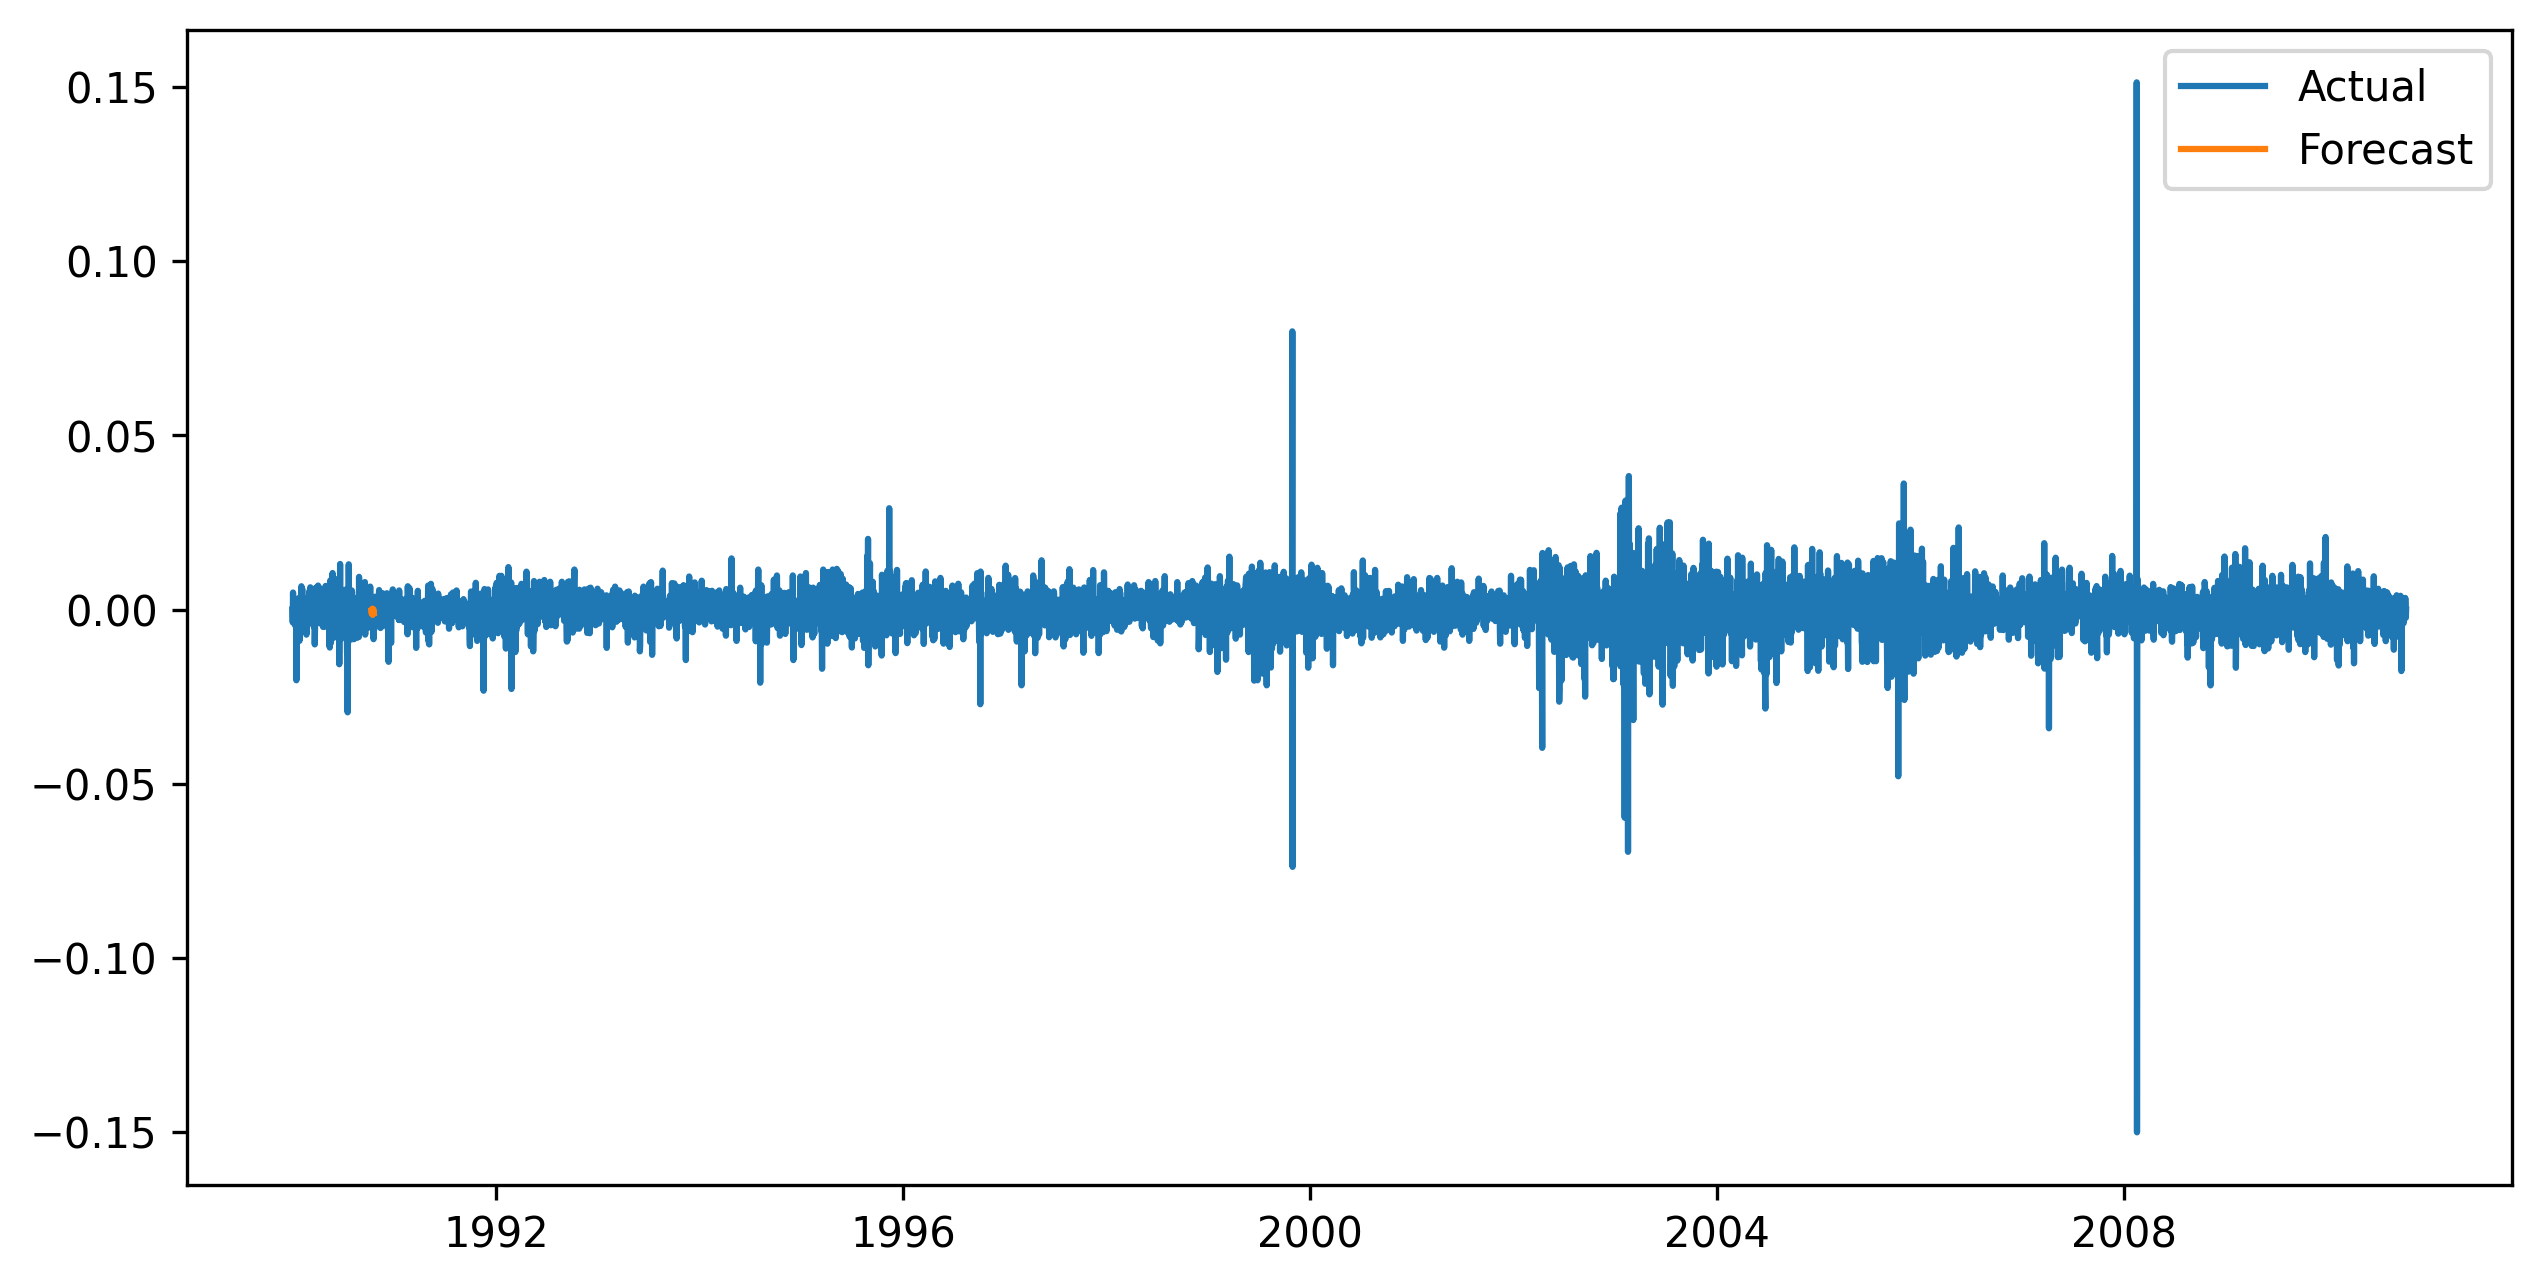

In [99]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Fit the model with the best parameters
# Initialize the model without smoothing parameters in the constructor
model = ExponentialSmoothing(df['diff_Ex_rate'], trend='add', seasonal='add', seasonal_periods=12)
# Fit the model and pass smoothing parameters to the fit method
model_fit = model.fit(smoothing_level=best_params[0], smoothing_trend=best_params[1], smoothing_seasonal=best_params[2])

# Generate forecasts
forecast = model_fit.forecast(steps=10)  # Adjust steps

# Visualize the forecast against actual data
plt.plot(df['date'], df['diff_Ex_rate'], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast')
plt.legend()
plt.show()

In [104]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fit the ARIMA model (replace (p, d, q) with your estimated values)
arima_model_fit = ARIMA(df['diff_Ex_rate'], order=(1, 0, 0)).fit()  # Replace (p, d, q) with your estimated values

# Generate forecasts using the ARIMA model
arima_forecast = arima_model_fit.get_forecast(steps=10).predicted_mean  # Adjust steps as needed



In [105]:
# Get forecasts using the Exponential Smoothing model
exp_smoothing_forecast = forecast  # Since 'forecast' is defined in previous code for exp smoothing

# Now calculate MAE, RMSE, and MAPE as before
arima_mae = mean_absolute_error(df['diff_Ex_rate'][-10:], arima_forecast)
exp_smoothing_mae = mean_absolute_error(df['diff_Ex_rate'][-10:], exp_smoothing_forecast)

# Calculate RMSE
arima_rmse = np.sqrt(mean_squared_error(df['diff_Ex_rate'][-10:], arima_forecast))
exp_smoothing_rmse = np.sqrt(mean_squared_error(df['diff_Ex_rate'][-10:], exp_smoothing_forecast))

# Calculate MAPE
def mape(actual, forecast):
    actual, forecast = np.array(actual), np.array(forecast)
    return np.mean(np.abs((actual - forecast) / actual)) * 100

arima_mape = mape(df['diff_Ex_rate'][-10:], arima_forecast)
exp_smoothing_mape = mape(df['diff_Ex_rate'][-10:], exp_smoothing_forecast)

# Print the error metrics
print("ARIMA - MAE:", arima_mae, "RMSE:", arima_rmse, "MAPE:", arima_mape)
print("Exp. Smoothing - MAE:", exp_smoothing_mae, "RMSE:", exp_smoothing_rmse, "MAPE:", exp_smoothing_mape)

ARIMA - MAE: 0.0014384245088754815 RMSE: 0.00194571229810091 MAPE: inf
Exp. Smoothing - MAE: 0.0020623382620536335 RMSE: 0.0023163982822205957 MAPE: inf


<ipython-input-105-65701e52e9b4>:15: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((actual - forecast) / actual)) * 100
